# Flowers Classification with Transfer Learning

## Project Setup

Import libraries

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from skimage import transform
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.random.set_seed(1234)

## Data Preparation

Load the dataset, rescale, then split into training and validation set

In [7]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

training_set = image_generator.flow_from_directory(batch_size=32,
                                                   directory="datasets/",
                                                   shuffle=False,
                                                   target_size=(180, 180),
                                                   subset="training",
                                                   class_mode="categorical")

validation_set = image_generator.flow_from_directory(batch_size=32,
                                                   directory="datasets/",
                                                   shuffle=False,
                                                   target_size=(180, 180),
                                                   subset="validation",
                                                   class_mode="categorical")

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [8]:
test_image_generator = ImageDataGenerator(rescale=1/255)

In [9]:
test_set = image_generator.flow_from_directory(batch_size=32,
                                                   directory="new_data/",
                                                   shuffle=False,
                                                   target_size=(180, 180),
                                                   class_mode="categorical")

Found 6 images belonging to 1 classes.


Show images for the first batch

In [20]:
class_names = list(training_set.class_indices)
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

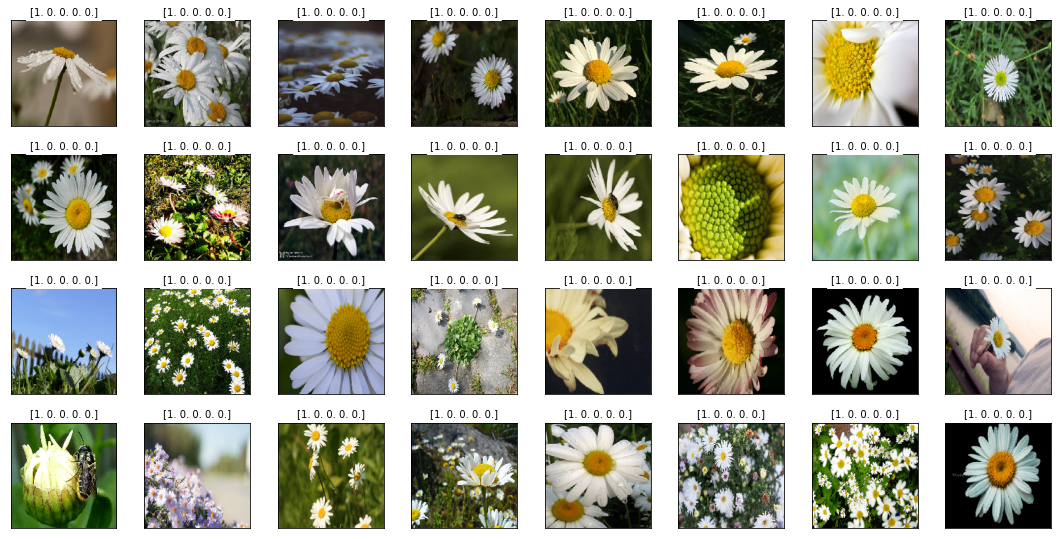

In [5]:
fig = plt.figure(figsize=(15, 15))

batch_1_img = training_set[0]
for i in range(32):
    digit = batch_1_img[0][i]
    label = batch_1_img[1][i]
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digit, cmap=plt.cm.binary)
    ax.set_title(str(label), backgroundcolor='white', fontsize=10)
plt.tight_layout()

## Model Training

In [6]:
model = Sequential()
inceptionv3_model = InceptionV3(input_shape=(180,180,3), 
                    weights='imagenet',
                    pooling='avg',classes=5,
                    include_top=False)

for layer in inceptionv3_model.layers:
    layer.trainable = False
    
model.add(inceptionv3_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

* include_top=False is used so that we can add custom input and output layers according to the data we are currently using
* use imagenet weight
* layer.trainable = False so that the model doesnt re-learning the weight, save time

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 1,051,653
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=10)

Epoch 1/10
92/92 [==============================] - 18s 118ms/step - loss: 2.0136 - accuracy: 0.5390 - val_loss: 0.9586 - val_accuracy: 0.6648
Epoch 2/10
92/92 [==============================] - 8s 85ms/step - loss: 0.7132 - accuracy: 0.7298 - val_loss: 0.6004 - val_accuracy: 0.7633
Epoch 3/10
92/92 [==============================] - 8s 86ms/step - loss: 0.6485 - accuracy: 0.7550 - val_loss: 0.5902 - val_accuracy: 0.7743
Epoch 4/10
92/92 [==============================] - 8s 88ms/step - loss: 0.4903 - accuracy: 0.8163 - val_loss: 0.5713 - val_accuracy: 0.7948
Epoch 5/10
92/92 [==============================] - 8s 89ms/step - loss: 0.5628 - accuracy: 0.7945 - val_loss: 0.5278 - val_accuracy: 0.8044
Epoch 6/10
92/92 [==============================] - 8s 88ms/step - loss: 0.4554 - accuracy: 0.8292 - val_loss: 0.5587 - val_accuracy: 0.7975
Epoch 7/10
92/92 [==============================] - 8s 90ms/step - loss: 0.4439 - accuracy: 0.8278 - val_loss: 0.5199 - val_accuracy: 0.8085
Epoch 8/10


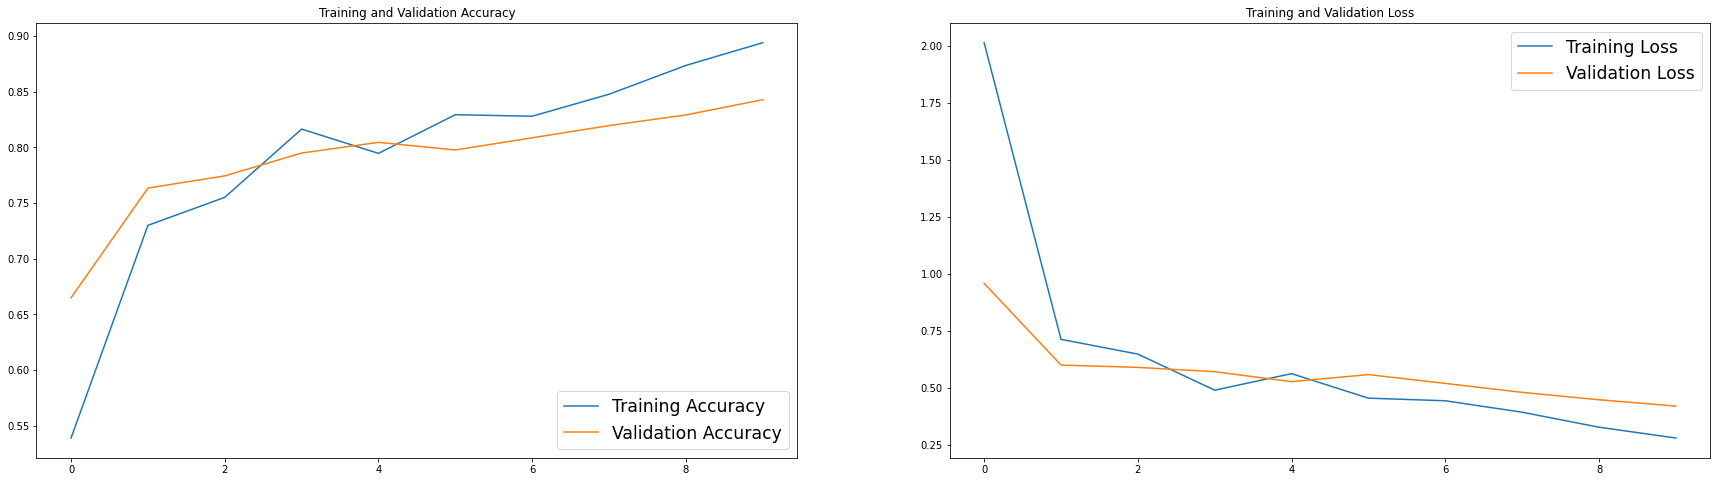

In [9]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right', fontsize="xx-large")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right', fontsize="xx-large")
plt.title('Training and Validation Loss')
plt.show()

In [5]:
# model.save("model/flower_classification_model.h5")

In [4]:
model = tf.keras.models.load_model("model/flower_classification_model.h5")

In [10]:
loss, accuracy = model.evaluate(training_set)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

92/92 [==============================] - 70s 691ms/step - loss: 0.2126 - accuracy: 0.9245
Loss:  0.2126363217830658
Accuracy:  0.9244641065597534


In [11]:
training_pred = np.argmax(model.predict(training_set), axis=1)

92/92 [==============================] - 7s 67ms/step


In [13]:
print(confusion_matrix(training_set.classes, training_pred))

[[454  17   7  25   4]
 [  6 686   0  23   4]
 [  2   3 466  23  19]
 [  1   5   1 552   1]
 [  1   4  47  29 559]]


In [14]:
loss, accuracy = model.evaluate(validation_set)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

23/23 [==============================] - 13s 586ms/step - loss: 0.4205 - accuracy: 0.8427
Loss:  0.42053741216659546
Accuracy:  0.8426812291145325


In [15]:
y_pred = np.argmax(model.predict(validation_set), axis=1)

23/23 [==============================] - 2s 65ms/step


In [16]:
print(confusion_matrix(validation_set.classes, y_pred))

[[110   5   3   7   1]
 [  3 150   4  19   3]
 [  1   1 103  10  13]
 [  0   6   3 127   3]
 [  2   1  15  15 126]]


In [92]:
def load(filename, class_names):
   np_image = PIL.Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (180, 180, 3))
   np_image = np.expand_dims(np_image, axis=0)
   pred = model.predict(np_image)
   output_class = class_names[np.argmax(pred)]
   print( f'The predicted class is {output_class}')
   return PIL.Image.open(filename)

1/1 [==============================] - 0s 27ms/step
The predicted class is roses


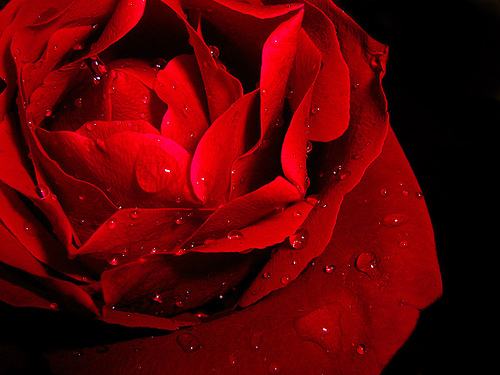

In [93]:
load("new_data/new_roses_1.jpg", class_names)

1/1 [==============================] - 0s 25ms/step
The predicted class is sunflowers


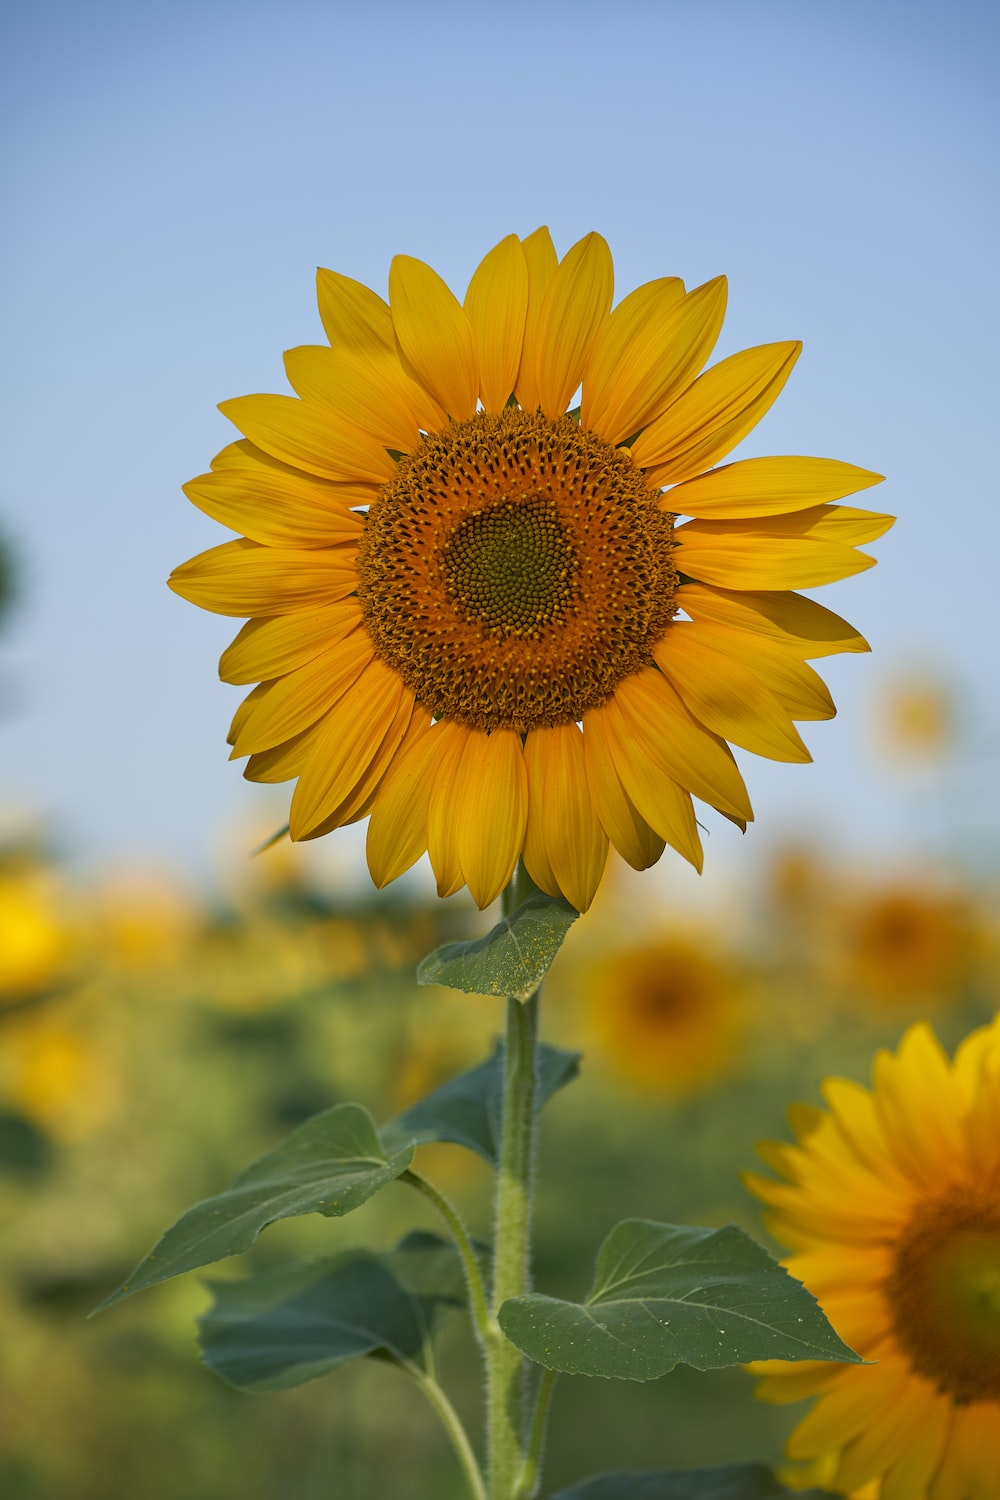

In [70]:
load("new_data/new_sunflowers_1.jpg", class_names)